# Hypothesis 1

In this notebook we will check if the the price p. sqft is higher in more densely populated places.
We check price per sqft lot as well as price per sqft of the living area to understand the data better.
The more densely populated places will be calculated as the average distance of all houses within the zipcode. 

In [34]:
import pandas as pd
import sys
import missingno as msno
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from haversine import haversine, Unit

from optional.data_processing import *


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)


df_all_housing_info = pd.read_csv('data/eda.csv')
df_all_housing_info.isna().sum()
#type(df_all_housing_info['date'][2])

#df_all_housing_info


id               0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
                ..
long             0
sqft_living15    0
sqft_lot15       0
date             0
price            0
Length: 21, dtype: int64

We don't need the following data: bedrooms, bathrooms, sqft_living15, sqft_lot15, date etc.
so we drop them to make calculations more efficient

In [35]:
df_all_housing_info = df_all_housing_info.drop(columns=['bedrooms','sqft_basement','sqft_above','bathrooms','condition','view','floors','grade','waterfront','yr_built', 'yr_renovated' ,'sqft_living15','sqft_lot15','date'])
df_all_housing_info

,id,sqft_living,sqft_lot,zipcode,lat,long,price
0,7129300520,1180.0,5650.0,98178,47.5112,-122.257,221900.0
1,6414100192,2570.0,7242.0,98125,47.7210,-122.319,538000.0
2,5631500400,770.0,10000.0,98028,47.7379,-122.233,180000.0
3,2487200875,1960.0,5000.0,98136,47.5208,-122.393,604000.0
4,1954400510,1680.0,8080.0,98074,47.6168,-122.045,510000.0
...,...,...,...,...,...,...,...
21592,263000018,1530.0,1131.0,98103,47.6993,-122.346,360000.0
21593,6600060120,2310.0,5813.0,98146,47.5107,-122.362,400000.0
21594,1523300141,1020.0,1350.0,98144,47.5944,-122.299,402101.0
21595,291310100,1600.0,2388.0,98027,47.5345,-122.069,400000.0


In [36]:
# Beispiel-DataFrame
# df = pd.DataFrame({'zipcode': [12345, 12345, 67890], 'lat': [52.52, 52.53, 48.85], 'long': [13.40, 13.41, 2.35]})

# Function to calculate the avg distance in a zipcode area
def calculate_avg_distance_per_zipcode(group):
    # All coordinates in a numpy-array
    coords = group[['lat', 'long']].to_numpy()
    

    # Create DF with each combination of distinct pairs of coordinates.
    pairs = pd.DataFrame(
        [(coords[i], coords[j]) for i in range(len(coords)) for j in range(i + 1, len(coords))],
        columns=['point1', 'point2']
    )
    
    # Calculate the distance of coordinates via haversine function and save them in a new column 
    pairs['distance'] = pairs.apply(
        lambda row: haversine(row['point1'], row['point2'], unit=Unit.FEET),
        axis=1
    )
    
    # Return the mean distance
    return pairs['distance'].mean()

#Create DF with zipcode and avg_distance
df_avg_dist = df_all_housing_info.groupby(
    'zipcode').apply(
        calculate_avg_distance_per_zipcode).reset_index(
        name='avg_distance')

/tmp/ipykernel_114301/1761192711.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'zipcode').apply(


Now we'll create extra rows that contain the avg prices per lot/living. Then we safe the average through a groupby in the variable df_avg_prices.


In [37]:
#Create copy of main DF
df_extra_data = df_all_housing_info.copy()

#Add avg_price per lot as column
df_extra_data['price_p_lot'] = df_extra_data['price']/df_extra_data['sqft_lot']

#Add avg_price per living area as column
df_extra_data['price_p_living'] = df_extra_data['price']/df_extra_data['sqft_living']

#Take the mean of the avg's and the count per zipcode
df_avg_prices = df_extra_data.groupby(
    'zipcode').agg(
        avg_price_p_lot=('price_p_lot',lambda x: x.mean().round()),
        avg_price_p_living=('price_p_living',lambda x: x.mean().round()),
        count=('price', 'count'))

In [38]:
#merge the avg distances and avg prices per zipcode in a df
df_plot = df_avg_dist.merge(df_avg_prices,on='zipcode')
df_plot

,zipcode,avg_distance,avg_price_p_lot,avg_price_p_living,count
0,98001,13972.115421,31.0,151.0,361
1,98002,9640.764253,37.0,151.0,199
2,98003,14218.417342,33.0,157.0,280
3,98004,9145.361957,123.0,476.0,317
4,98005,9882.870374,61.0,315.0,168
...,...,...,...,...,...
65,98177,12054.510660,71.0,293.0,255
66,98178,5603.937687,43.0,189.0,262
67,98188,5926.187752,31.0,169.0,136
68,98198,9939.782089,36.0,178.0,280


/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


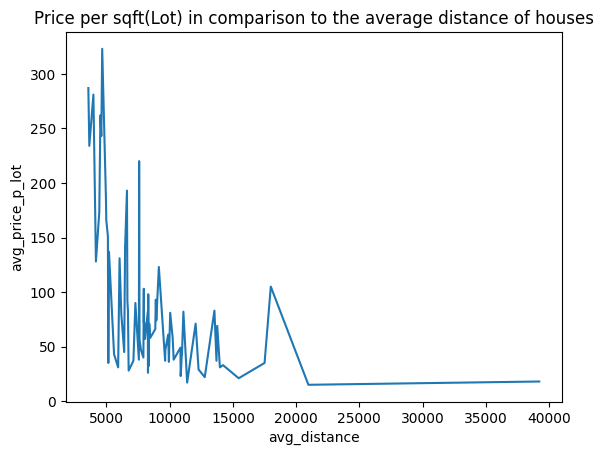

In [42]:
#Plot avg price per lot by the avg distance
sns.lineplot(data=df_plot, x='avg_distance', y='avg_price_p_lot')
plt.title('Price per sqft(Lot) in comparison to the average distance of houses')

plt.savefig('data/distance_lot_price.png', dpi=300, bbox_inches='tight')


/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


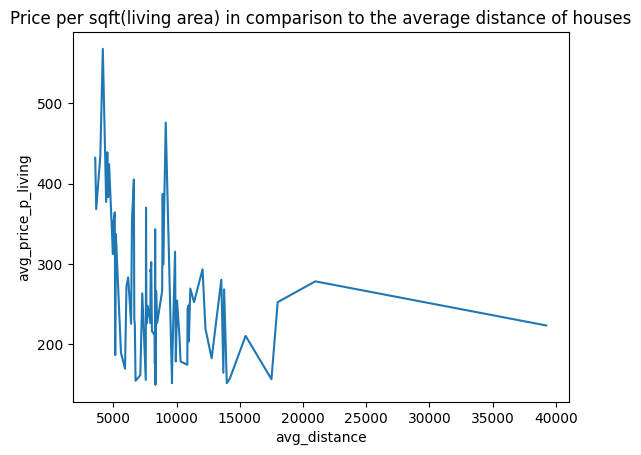

In [44]:
#Plot avg price per living area by the avg distance
sns.lineplot(data=df_plot, x='avg_distance', y='avg_price_p_living')
plt.title('Price per sqft(living area) in comparison to the average distance of houses')

plt.savefig('data/distance_living_price.png', dpi=300, bbox_inches='tight')